In [4]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, LSTM, Dense, Dropout,
                                     Bidirectional, GlobalAveragePooling1D,
                                     Attention, Concatenate)
from tensorflow.keras.optimizers import Adam
from IPython.display import Audio

In [5]:

!unzip "/content/archive (8).zip"

Streaming output truncated to the last 5000 lines.
  inflating: AudioWAV/1031_DFA_DIS_XX.wav  
  inflating: AudioWAV/1031_DFA_FEA_XX.wav  
  inflating: AudioWAV/1031_DFA_HAP_XX.wav  
  inflating: AudioWAV/1031_DFA_NEU_XX.wav  
  inflating: AudioWAV/1031_DFA_SAD_XX.wav  
  inflating: AudioWAV/1031_IEO_ANG_HI.wav  
  inflating: AudioWAV/1031_IEO_ANG_LO.wav  
  inflating: AudioWAV/1031_IEO_ANG_MD.wav  
  inflating: AudioWAV/1031_IEO_DIS_HI.wav  
  inflating: AudioWAV/1031_IEO_DIS_LO.wav  
  inflating: AudioWAV/1031_IEO_DIS_MD.wav  
  inflating: AudioWAV/1031_IEO_FEA_HI.wav  
  inflating: AudioWAV/1031_IEO_FEA_LO.wav  
  inflating: AudioWAV/1031_IEO_FEA_MD.wav  
  inflating: AudioWAV/1031_IEO_HAP_HI.wav  
  inflating: AudioWAV/1031_IEO_HAP_LO.wav  
  inflating: AudioWAV/1031_IEO_HAP_MD.wav  
  inflating: AudioWAV/1031_IEO_NEU_XX.wav  
  inflating: AudioWAV/1031_IEO_SAD_HI.wav  
  inflating: AudioWAV/1031_IEO_SAD_LO.wav  
  inflating: AudioWAV/1031_IEO_SAD_MD.wav  
  inflating: AudioWAV/103

In [6]:
import warnings
warnings.filterwarnings("ignore")

### STEP 1: DATA LOADING AND LABELING ###
# Define dataset path
DATASET_DIR = "/content/AudioWAV"
file_list = os.listdir(DATASET_DIR)

In [7]:
# Map emotions from filenames
emotion_map = {
    'SAD': 'sad',
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral'
}

In [8]:
def extract_emotion(filename):
    """Extract emotion from the filename."""
    parts = filename.split('_')
    return emotion_map.get(parts[2], 'unknown') if len(parts) > 2 else 'unknown'

# Create a dataframe
data_records = []
for file in file_list:
    file_path = os.path.join(DATASET_DIR, file)
    emotion = extract_emotion(file)
    data_records.append((file_path, emotion))

df = pd.DataFrame(data_records, columns=['Path', 'Emotion'])
print(df.head())

                                    Path  Emotion
0  /content/AudioWAV/1055_IOM_NEU_XX.wav  neutral
1  /content/AudioWAV/1047_IEO_FEA_HI.wav     fear
2  /content/AudioWAV/1051_IOM_NEU_XX.wav  neutral
3  /content/AudioWAV/1036_ITS_FEA_XX.wav     fear
4  /content/AudioWAV/1023_IWW_NEU_XX.wav  neutral


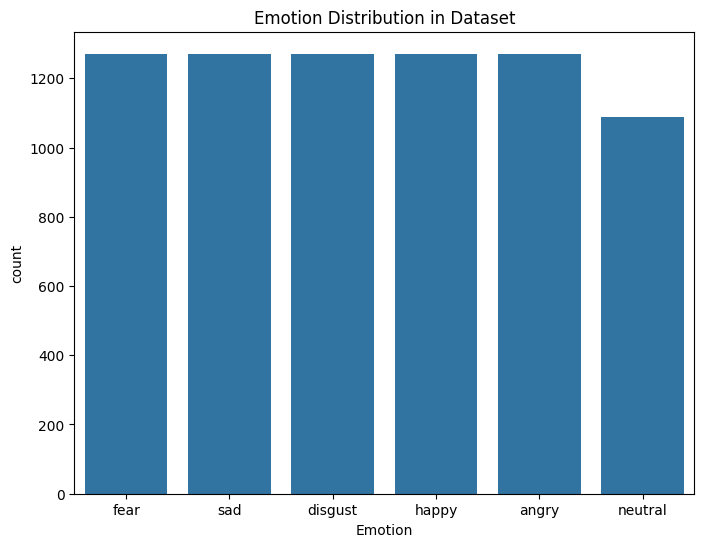

In [9]:
# Visualize emotion counts
plt.figure(figsize=(8, 6))
sns.countplot(x='Emotion', data=df, order=df['Emotion'].value_counts().index)
plt.title("Emotion Distribution in Dataset")
plt.show()


In [10]:
# Encode labels
emotion_labels = {'disgust': 0, 'happy': 1, 'sad': 2, 'neutral': 3, 'fear': 4, 'angry': 5}
df['Label'] = df['Emotion'].map(emotion_labels)


##STEP 2: FEATURE EXTRACTION

In [11]:
# Parameters for MFCC extraction
NUM_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
DURATION = 5  # seconds
SAMPLE_RATE = 22050
MAX_FRAMES = 300  # Fixed frame count for truncation/padding

In [12]:
def extract_features(file_path):
    """Extract MFCC, delta, and delta-delta features."""
    try:
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        signal = librosa.util.normalize(signal)

        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=NUM_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
        delta = librosa.feature.delta(mfcc)
        delta_delta = librosa.feature.delta(mfcc, order=2)

        # Stack features and truncate/pad
        features = np.vstack([mfcc, delta, delta_delta]).T
        if features.shape[0] < MAX_FRAMES:
            padding = np.zeros((MAX_FRAMES - features.shape[0], features.shape[1]))
            features = np.vstack([features, padding])
        return features[:MAX_FRAMES, :]
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return np.zeros((MAX_FRAMES, NUM_MFCC * 3))


In [13]:
# Extract features and labels
X, y = [], []
for _, row in df.iterrows():
    features = extract_features(row['Path'])
    X.append(features)
    y.append(row['Label'])

X = np.array(X)
y = np.array(y)
print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")


Feature shape: (7442, 300, 39), Labels shape: (7442,)


##STEP 3: TRAIN-TEST SPLIT

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training: {X_train.shape}, Validation: {X_val.shape}, Testing: {X_test.shape}")

Training: (5953, 300, 39), Validation: (744, 300, 39), Testing: (745, 300, 39)


##STEP 4: MODEL ARCHITECTURE

In [15]:
def build_emotion_model(input_shape):
    """Build Bi-LSTM with Attention."""
    inputs = Input(shape=input_shape)

    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm_out = Dropout(0.3)(lstm_out)
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)

    attention_output = Attention()([lstm_out, lstm_out])
    context_vector = Concatenate()([attention_output, lstm_out])

    pooled_output = GlobalAveragePooling1D()(context_vector)
    dense = Dense(64, activation='relu')(pooled_output)
    dense = Dropout(0.3)(dense)

    outputs = Dense(len(emotion_labels), activation='softmax')(dense)
    return Model(inputs, outputs)

# Build and compile model
model = build_emotion_model((MAX_FRAMES, NUM_MFCC * 3))
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 300, 39)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 300, 256)       │        172,032 │ input_layer[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 300, 256)       │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 300, 128)       │        164,352 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 300, 128)       │              0 │ bidirectional_1[0][0], │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 300, 256)       │              0 │ attention[0][0],       │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 256)            │              0 │ concatenate[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         16,448 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 6)              │            390 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 353,222 (1.35 MB)

 Trainable params: 353,222 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

## STEP 5: MODEL TRAINING

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    batch_size=32, epochs=30, verbose=1)


Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.3312 - loss: 1.5942 - val_accuracy: 0.4355 - val_loss: 1.4031
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.4448 - loss: 1.3939 - val_accuracy: 0.4516 - val_loss: 1.3998
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.4590 - loss: 1.3622 - val_accuracy: 0.4785 - val_loss: 1.3329
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.4872 - loss: 1.2803 - val_accuracy: 0.4409 - val_loss: 1.3218
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5123 - loss: 1.2489 - val_accuracy: 0.5323 - val_loss: 1.2249
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.5495 - loss: 1.1863 - val_accuracy: 0.4825 - val_loss: 1.3671
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5596 - loss: 1.1661 - val_accuracy: 0.5188 - val_loss: 1.2199
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.5858 - loss: 1.0933 - va

##STEP 6: MODEL EVALUATION

In [17]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.2f}")

Test Accuracy: 0.58


In [18]:
# Predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=emotion_labels.keys()))

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
              precision    recall  f1-score   support

     disgust       0.52      0.53      0.53       116
       happy       0.49      0.62      0.55       128
         sad       0.52      0.55      0.53       114
     neutral       0.56      0.77      0.65       105
        fear       0.74      0.29      0.42       148
       angry       0.72      0.75      0.74       134

    accuracy                           0.58       745
   macro avg       0.59      0.59      0.57       745
weighted avg       0.60      0.58      0.56       745



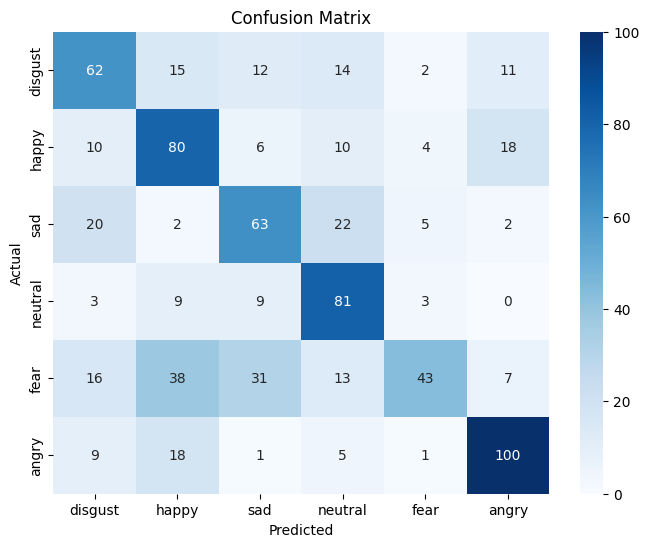

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

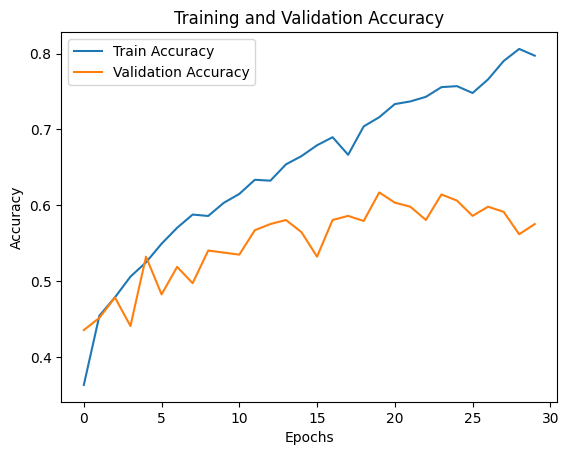

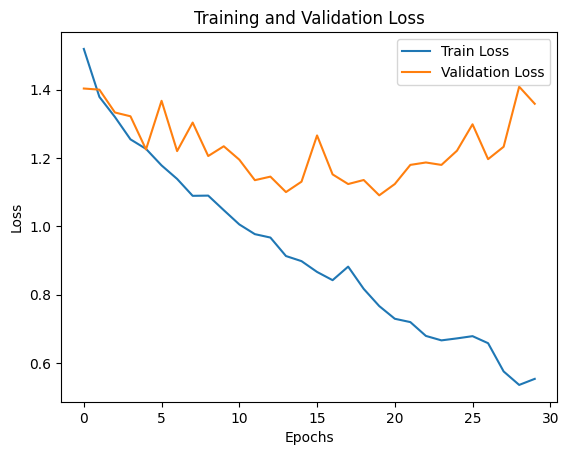

In [20]:

# Training curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()